https://discourse.pymc.io/t/is-it-possible-to-convert-column-from-pandas-to-theano-shared/728/9

In [1]:
%pylab inline
import pymc3 as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import theano.tensor as tt
import theano

Populating the interactive namespace from numpy and matplotlib


In [2]:
RAILS = pd.read_csv('./brit_rail_acc.csv')

In [9]:
RAILS

,year,mil_km,cdo_acc,cdo_fat,car_acc,car_fat,mn_acc,mn_fat
0,1946,600,9,38,7,16,370,378
1,1947,571,10,99,9,20,298,304
2,1948,589,10,48,11,20,273,273
3,1949,613,4,5,5,5,278,281
4,1950,618,5,13,14,19,247,250
5,1951,605,7,47,7,8,231,233
6,1952,605,7,120,12,13,249,254
7,1953,610,6,18,12,19,278,286
8,1954,608,1,1,10,11,215,217
9,1955,584,8,48,11,11,246,246


In [10]:
np.log(RAILS['cdo_acc'])

0     2.197225
1     2.302585
2     2.302585
3     1.386294
4     1.609438
5     1.945910
6     1.945910
7     1.791759
8     0.000000
9     2.079442
10    1.386294
11    1.386294
12    1.609438
13    1.098612
14    1.609438
15    2.079442
16    0.693147
17    1.609438
18    1.791759
19    1.609438
20    0.000000
21    1.791759
22    1.098612
23    1.945910
24    0.693147
25    1.945910
26    0.693147
27    1.098612
28    0.693147
29    1.609438
30    0.693147
31    0.000000
32    0.693147
33    1.098612
34    0.693147
35    0.693147
36    0.693147
37    0.693147
38    1.609438
39        -inf
40    0.693147
41    0.000000
42    0.693147
43    1.386294
44    0.000000
45    0.693147
46    0.000000
47        -inf
48    0.693147
49    0.000000
50    0.693147
51    0.000000
52        -inf
53    0.000000
54    0.000000
55        -inf
56    0.000000
57        -inf
Name: cdo_acc, dtype: float64

In [15]:
from scipy.stats import zscore
RAILS['mil_km_z'] = zscore(RAILS['mil_km'])
RAILS['year_z'] = zscore(RAILS['year'])

BR = RAILS[21:47]  # Data prior to privatisation, but after the steam engine
ABR = RAILS[48:]  # Data after privatisation
GBR = RAILS[21:]  # Data for the comparison plot

DISTANCE = theano.shared(BR['mil_km_z'].values)
YEAR = theano.shared(BR['year_z'].values)

with pm.Model() as MODEL_BR_0:
    A = pm.Normal('alpha', mu=0, sd=100)
    BD = pm.Normal('distance', mu=0, sd=10)
    BY = pm.Normal('year', mu=0, sd=10)
# There is no reason to assume that year affects the outcome, but as is stated,
# British Rail was running new safety measures and they are assumed to continue,
# therefore there must be at least some weak effect present

    theta = A + BD * DISTANCE + BY * YEAR
    y = pm.Poisson('accidents', mu=tt.exp(theta),
            observed=BR['cdo_acc'].values)

    trace = pm.sample(1000, tune=1000)

ppc = pm.sample_ppc(trace, model=MODEL_BR_0)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [year, distance, alpha]
INFO:pymc3:NUTS: [year, distance, alpha]
100%|██████████| 2000/2000 [00:05<00:00, 357.77it/s]
The acceptance probability does not match the target. It is 0.885707326749, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 1000/1000 [00:00<00:00, 2442.50it/s]


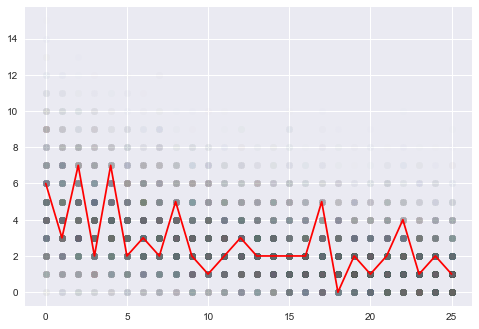

In [19]:
plt.plot(ppc['accidents'].T, 'o',alpha=.01)
plt.plot(BR['cdo_acc'].values, 'r')

In [12]:
DISTANCE.set_value(ABR['mil_km_z'].values)
YEAR.set_value(ABR['year_z'].values)

ppc = pm.sample_ppc(trace, model=MODEL_BR_0)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [year, distance, alpha]
INFO:pymc3:NUTS: [year, distance, alpha]
100%|██████████| 2000/2000 [00:05<00:00, 391.52it/s]


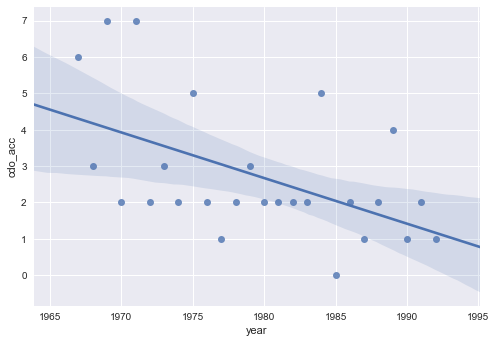

In [14]:
sns.regplot(x="year", y="cdo_acc", data=BR);
#    plt.show()